In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
from glob import glob
import re

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import torch.optim
from torchvision.transforms import ToTensor, Normalize

from predictive_coding.dataset import collate_fn, EnvironmentDataset, CircleDataset
from predictive_coding.trainer import Trainer
from predictive_coding import Autoencoder, PredictiveCoder, VestibularCoder


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/mag/predictive-coding-recovers-maps/notebooks/predictive_coding/trainer.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment = '0.1-0.1'
num_actions = experiment.count('-') + 1
vestibular = False

device = 'cuda:1'

experiment_name = f'predictive-coding-{experiment}-vestibular' if vestibular else f'predictive-coding-{experiment}'
if vestibular:
    model = VestibularCoder(in_channels=3, out_channels=3, layers=[2, 2, 2, 2], seq_len=20, num_actions=num_actions)
else:
    model = PredictiveCoder(in_channels=3, out_channels=3, layers=[2, 2, 2, 2], seq_len=20)

model.load_state_dict(torch.load(f'./experiments/{experiment_name}/best.ckpt'))
model.eval()
model = model.to(device)

In [3]:
val_dataset = EnvironmentDataset(Path(f"/home/mag/malmo/datasets/random-dataset-0.1-0.1/validate"), sequence_length=20)
dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=10,
    pin_memory=True,
)

In [4]:
residual = 0

latents = []
positions = []
object_encodings = []
object_locs = []
for batch_idx, batch in enumerate(tqdm(dataloader)):
    images, actions, states = batch
    #images, actions, states, objects, obj_locs = batch
    B, L, C, H, W = images.shape
    #_, _, N, D = obj_locs.shape
    images = images.to(device)
    #objects = objects.reshape(B*L, -1)
    #obj_locs = obj_locs.reshape(B*L, N, D)
    #print(obj_locs.shape)

    with torch.no_grad():
        features = model.get_latents(images, actions=actions, which=residual).reshape(B*L, 128, 8, 8)
        latents.append(features.cpu())
        positions.append(states.reshape(B*L, 3))
        #object_encodings.append(objects)
        #object_locs.append(obj_locs)

latents = torch.cat(latents, dim=0).cpu().numpy()
positions = torch.cat(positions, dim=0).cpu().numpy()
#object_encodings = torch.cat(object_encodings, dim=0).cpu().numpy()
#object_locs = torch.cat(object_locs, dim=0).cpu().numpy()
#print(object_locs.shape)

100%|███████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


In [5]:
latents.shape

(80000, 8192)

In [5]:
latents = np.mean(latents, axis=(2,3))

In [ ]:
positions.shape

In [ ]:
hist = plt.hist2d(positions[:, 0], positions[:, 1], bins=(41, 66), cmap='Blues', range=[[-22, 22], [-30, 36]])
plt.colorbar(label='Num visits')
plt.title("0.1 heatmap (no-vest)")


Text(0.5, 1.0, '0.1 heatmap (no-vest)')

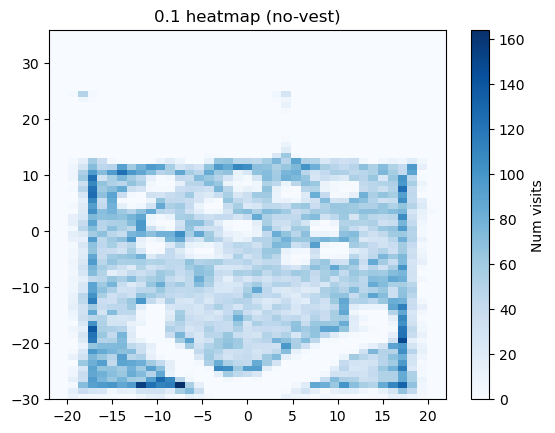

In [6]:
# crop positions to remove some of the hot spots
idx = positions[:,1] < 25
cropped_positions = positions[idx]
cropped_latents = latents[idx]

hist = plt.hist2d(cropped_positions[:, 0], cropped_positions[:, 1], bins=(41, 66), cmap='Blues', range=[[-22, 22], [-30, 36]])
plt.colorbar(label='Num visits')
plt.title("0.1 heatmap (no-vest)")

Text(0.5, 1.0, '0.1 heatmap yaw (no-vest)')

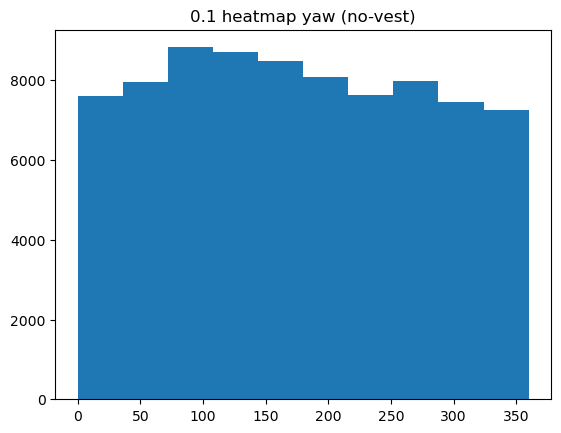

In [7]:
yaws = (positions[:, 2] / np.pi * 180) % 360
hist = plt.hist(yaws)
plt.title("0.1 heatmap yaw (no-vest)")


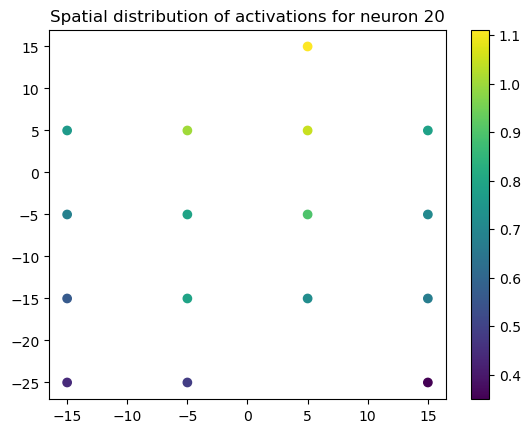

In [11]:
i = 20

lambda_i = np.array([np.mean(t_latents[i][np.all(binned_coords == bin, axis=1)]) for bin in unique_bins])

plt.scatter(unique_bins[:, 0], unique_bins[:, 1], c=lambda_i, cmap='viridis')
plt.colorbar()
plt.title(f'Spatial distribution of activations for neuron {i}')
plt.show()

In [71]:
# Transform the latent value into a firing rate via percentile ranking (not currently used)
percentile_ranked_latents = np.zeros_like(latents)
for i in range(latents.shape[1]):
    percentile_ranked_latents[:, i] = stats.rankdata(latents[:, i], method='average') / len(latents) * 100

In [77]:
print(unique_bins[0], unique_bins[12], unique_bins[22]) 
print(len(unique_bins))

[-17 -31] [-10  -3] [  3 -31]
44


In [32]:
t_latents

array([[0.        , 0.        , 0.05845899, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05311078, ..., 0.        , 0.03333057,
        0.        ],
       [0.        , 0.        , 0.02818355, ..., 0.        , 0.09191404,
        0.10781251],
       ...,
       [0.03392563, 0.0076475 , 0.05919439, ..., 0.03947515, 0.10651343,
        0.07806882],
       [0.        , 0.01627738, 0.06427306, ..., 0.07013154, 0.024592  ,
        0.01366209],
       [0.09094577, 0.03650436, 0.04047733, ..., 0.06588981, 0.02591802,
        0.00993512]], dtype=float32)

In [7]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# I feel like maybe it is dumb/arbitrary to average across the 8x8 for the 128 latents so I maybe won't?

def bin_coord(coord, bin_size=7):
    signs = np.sign(coord)
    binned = np.floor(np.abs(coord) / bin_size) * bin_size
    binned *= signs
    binned += (bin_size / 2) * signs
    return binned.astype(int)

binned_coords = [bin_coord(coord) for coord in cropped_positions[:, :2]]
binned_coords = np.stack(binned_coords)

unique_bins, counts = np.unique(binned_coords, return_counts=True, axis=0)

# screen out the positions and latents that aren't visited enough
min_visits = np.percentile(counts, 15) # if you're using a bin size of 4 50 is about appropriate
valid_bins_mask = counts >= min_visits

unique_bins = unique_bins[valid_bins_mask]
counts = counts[valid_bins_mask]

# also screen out all of the individual positions and the latents associated with them
valid_indexes = []
for i, coord in enumerate(binned_coords):
    if any(np.all(coord == valid_bin) for valid_bin in unique_bins):
        valid_indexes.append(i)

valid_indexes = np.array(valid_indexes)
binned_coords = binned_coords[valid_indexes]
t_latents = cropped_latents[valid_indexes].T

# normalize latents
t_latents = (t_latents - np.min(t_latents))/(np.max(t_latents) - np.min(t_latents))

# get the probability of being in each location bin
p_i = counts / len(unique_bins)

results = []
n_shuffles = 1000
significance_level = 0.99

epsilon = 1

for i, latent in enumerate(t_latents):
    #thresh = np.percentile(latent, 95)
    #binary_latent = latent > thresh

    binary_latent = latent * 10000
    lambda_mean = np.mean(binary_latent)

    # mean per location
    l = binary_latent[np.all(binned_coords == unique_bins[0], axis=1)]
    lambda_i = np.array([np.mean(binary_latent[np.all(binned_coords == bin, axis=1)]) for bin in unique_bins])

    sic = np.sum(p_i * ((lambda_i + epsilon) / (lambda_mean)) * np.log2((lambda_i + epsilon) / (lambda_mean)))

    null_sics = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        #shuffled_indices = np.random.permutation(binary_latent.shape[0])
        shuffled_latents = np.roll(binary_latent, np.random.randint(0, 100))#binary_latent[shuffled_indices]
        lambda_i_shuffled = np.array([np.mean(shuffled_latents[np.all(binned_coords == bin, axis=1)]) for bin in unique_bins])
        null_sic = np.sum(p_i * ((lambda_i_shuffled + epsilon) / (lambda_mean)) * np.log2((lambda_i_shuffled + epsilon) / (lambda_mean)))
        null_sics[i] = null_sic
    
    significance_threshold = np.percentile(null_sics, significance_level * 100)
    is_significant = sic > significance_threshold
    normalized_sic = sic - np.mean(null_sics)

    print('null sic thresh', significance_threshold)
    print('sic', sic)
    print(is_significant)
    print()

    results.append((sic, normalized_sic, is_significant))

proportion_significant = sum(result[2] for result in results) / len(results)
print(f"Proportion of significant neurons: {proportion_significant:.2%}")

null sic thresh 20.88388819505457
sic 21.278207742360717
True

null sic thresh 39.71895740506574
sic 40.58305652872906
True

null sic thresh 35.67426104630849
sic 36.4361748706053
True

null sic thresh 86.47137525145206
sic 86.47137525145206
False



KeyboardInterrupt: 

In [9]:
t_latents[:100] * 200

array([[ 0.       ,  0.       , 11.691797 , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       , 10.622156 , ...,  0.       ,  6.6661134,
         0.       ],
       [ 0.       ,  0.       ,  5.6367097, ...,  0.       , 18.382807 ,
        21.562502 ],
       ...,
       [ 3.080441 , 21.294085 ,  0.       , ...,  5.6705217, 15.352244 ,
        12.416327 ],
       [ 5.127925 ,  0.       ,  0.       , ..., 14.267379 ,  5.71894  ,
        13.452919 ],
       [19.71327  , 16.4272   ,  0.       , ..., 22.137732 ,  6.519295 ,
         0.       ]], dtype=float32)

In [98]:
counts

array([], dtype=int64)

In [8]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit
from multiprocessing import Pool

def calculate_null_sics(latent, positions, unique_bins, p_i, lambda_mean, n_shuffles):
    epsilon = 1
    null_sics = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        shuffled_latents = np.roll(latent, np.random.randint(0, 100))
        lambda_i_shuffled = np.array([np.mean(shuffled_latents[np.all(binned_coords == bin, axis=1)]) for bin in unique_bins])
        null_sic = np.sum(p_i * ((lambda_i_shuffled + epsilon) / (lambda_mean)) * np.log2((lambda_i_shuffled + epsilon) / (lambda_mean)))
        null_sics[i] = null_sic
    return null_sics

def process_latent(args):
    latent, positions, unique_bins, p_i, n_shuffles, significance_level = args
    #threshold = np.percentile(latent, 5)
    binary_latent = latent * 10000
    
    lambda_mean = np.mean(binary_latent)
    
    # mean per position
    lambda_i = np.array([np.mean(binary_latent[np.all(positions == bin, axis=1)]) for bin in unique_bins])
    
    epsilon = 1
    sic = np.sum(p_i * (lambda_i / lambda_mean) * np.log2((lambda_i + epsilon) / (lambda_mean)))
    
    null_sics = calculate_null_sics(binary_latent, positions, unique_bins, p_i, lambda_mean, n_shuffles)
    
    significance_threshold = np.percentile(null_sics, significance_level * 100)
    is_significant = sic > significance_threshold
    normalized_sic = sic - np.mean(null_sics)
    
    return sic, normalized_sic, is_significant

def bin_coord(coord, bin_size=7):
    signs = np.sign(coord)
    binned = np.floor(np.abs(coord) / bin_size) * bin_size
    binned *= signs
    binned += (bin_size / 2) * signs
    return binned.astype(int)

binned_coords = [bin_coord(coord) for coord in cropped_positions[:, :2]]
binned_coords = np.stack(binned_coords)

unique_bins, counts = np.unique(binned_coords, return_counts=True, axis=0)

# screen out the positions and latents that aren't visited enough
min_visits = np.percentile(counts, 15) # if you're using a bin size of 4 50 is about appropriate
valid_bins_mask = counts >= min_visits

unique_bins = unique_bins[valid_bins_mask]
counts = counts[valid_bins_mask]

# also screen out all of the individual positions and the latents associated with them
valid_indexes = []
for i, coord in enumerate(binned_coords):
    if any(np.all(coord == valid_bin) for valid_bin in unique_bins):
        valid_indexes.append(i)

valid_indexes = np.array(valid_indexes)
binned_coords = binned_coords[valid_indexes]
t_latents = cropped_latents[valid_indexes].T

# normalize latents
t_latents = (t_latents - np.min(t_latents))/(np.max(t_latents) - np.min(t_latents))

# get the probability of being in each location bin
p_i = counts / len(unique_bins)

results = []
n_shuffles = 1000
significance_level = 0.99

args_list = [(latent, binned_coords, unique_bins, p_i, n_shuffles, significance_level) for latent in t_latents]

with Pool() as pool:
    results = list(tqdm(pool.imap(process_latent, args_list), total=len(t_latents)))

results = np.array(results)


100%|█████████████████████████████████████████| 128/128 [06:51<00:00,  3.22s/it]


In [9]:
results

array([[ 21.29008482,  15.58793534,   1.        ],
       [ 40.60672147,  31.25290887,   1.        ],
       [ 36.45760192,  26.78449967,   1.        ],
       [ 86.49992734,  66.40200841,   1.        ],
       [  5.77716663,   3.92329175,   1.        ],
       [ 61.81960945,  47.55245874,   1.        ],
       [ 12.72676716,   8.62905434,   1.        ],
       [105.05364089,  82.10769389,   1.        ],
       [  9.77970566,   7.17675775,   1.        ],
       [ 73.1389857 ,  56.29599462,   1.        ],
       [103.33211196,  79.25947387,   1.        ],
       [ 48.4686394 ,  38.21816494,   1.        ],
       [ 34.16593403,  26.15867765,   1.        ],
       [143.2675014 , 115.00293989,   1.        ],
       [ 79.42837985,  61.01271342,   1.        ],
       [141.99548732, 116.3856047 ,   1.        ],
       [ 84.16176993,  67.5381245 ,   1.        ],
       [217.85425716, 170.98088644,   1.        ],
       [ 49.78109426,  38.58875695,   1.        ],
       [ 39.36818288,  29.87658

In [9]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# I feel like maybe it is dumb/arbitrary to average across the 8x8 for the 128 latents so I maybe won't?
def bin_yaw(yaw, bin_size = 10): # in degrees
    binned = np.floor(yaw / bin_size) * bin_size
    return binned.astype(int)

binned_yaws = [bin_yaw(yaw) for yaw in yaws]
binned_yaws = np.stack(binned_yaws)

unique_bins, counts = np.unique(binned_yaws, return_counts=True, axis=0)

min_visits = 50 
valid_bins_mask = counts >= min_visits

unique_bins = unique_bins[valid_bins_mask]
counts = counts[valid_bins_mask]

p_i = counts / len(unique_bins)

results = []
n_shuffles = 100
significance_level = 0.95

epsilon = 1e-30

for i, latent in tqdm(enumerate(latents.T[:20]), total=len(latents.T[:20])):
    #threshold = np.percentile(latent, firing_percentile)
    #binary_latent = (latent > threshold).astype(int)
    binary_latent = latent * 00
    
    lambda_mean = np.mean(binary_latent)

    # mean per location
    lambda_i = np.array([np.mean(binary_latent[binned_yaws == bin]) for bin in unique_bins])
    
    sic = np.sum(p_i * (lambda_i / (lambda_mean)) * np.log2((lambda_i) / (lambda_mean)))

    null_sics = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        shuffled_indices = np.random.permutation(len(binned_yaws))
        shuffled_positions = binned_yaws[shuffled_indices]
        lambda_i_shuffled = np.array([np.mean(binary_latent[shuffled_positions == bin]) for bin in unique_bins])
        shuffled_unique_bins, shuffled_counts = np.unique(shuffled_positions, return_counts=True, axis=0)
        
        valid_bins_mask = shuffled_counts >= min_visits
        shuffled_p_i = shuffled_counts[valid_bins_mask] / len(shuffled_unique_bins[valid_bins_mask])
        
        null_sic = np.sum(shuffled_p_i * (lambda_i_shuffled / (lambda_mean)) * np.log2((lambda_i_shuffled) / (lambda_mean)))
        null_sics[i] = null_sic
    
    significance_threshold = np.percentile(null_sics, significance_level * 100)
    is_significant = sic > significance_threshold
    normalized_sic = sic - np.mean(null_sics)

    print(null_sics)
    print(sic)

    results.append((sic, normalized_sic, is_significant))

proportion_significant = sum(result[2] for result in results) / len(results)
print(f"Proportion of significant neurons: {proportion_significant:.2%}")

  5%|██▏                                         | 1/20 [00:04<01:29,  4.73s/it]

[1.0309011  1.16581311 0.8996242  1.00486495 0.57562244 1.01175482
 0.99445832 0.80144691 0.70918784 0.71873603 0.56849917 0.70359824
 0.74516659 0.87703358 1.04400013 0.90046727 1.18343366 0.89599714
 0.86584434 0.91859837 0.86569006 0.70107095 0.77740082 0.58059239
 1.13886173 0.63118451 0.89584171 0.83703013 0.90931961 0.58533712
 0.59559608 0.84202133 1.01636328 0.9346279  0.67672637 0.84500094
 0.69620358 0.88736094 1.1113064  0.44426804 0.79187673 0.5708426
 0.93163761 0.4552193  0.68483052 1.34302415 0.77524258 0.84676328
 0.57907694 0.65085762 0.87450936 1.03380792 0.85299782 0.75453498
 0.55385746 0.87660117 0.55279585 0.84145458 1.00303831 0.65012221
 0.8559644  0.64430028 0.65475751 0.87647447 0.98173231 0.78241463
 0.89589342 0.62662896 1.10776478 1.43963259 1.01674774 0.53850241
 0.50395776 0.68299992 0.92983486 0.76172488 0.812238   0.65975466
 0.7724989  0.85754028 1.10292866 0.58553527 1.12365942 0.82810001
 0.90009734 0.98841832 0.65612216 0.94206601 0.64375279 0.59532

 10%|████▍                                       | 2/20 [00:10<01:31,  5.10s/it]

[1.01689022 1.30003318 1.25792982 1.05276603 1.40811497 2.01752371
 1.63754904 1.56744325 1.20171023 0.9125704  1.76846561 2.10046415
 1.19152241 2.12410649 1.15678399 1.21522459 0.79084675 1.39593518
 0.90754238 1.97552874 1.72697674 1.76974572 1.47901743 1.4078062
 1.34636301 1.45306387 1.08321084 1.13903625 1.4204813  1.51972418
 2.19726102 1.40816946 0.87620254 0.96825716 1.42116223 0.97981865
 1.03054391 1.92032373 1.71407415 1.60628239 1.0069737  1.44974259
 1.75253522 1.73551921 1.64845921 1.50769441 1.71687151 1.68343551
 1.61282793 1.19790192 1.26042936 1.61908732 1.10859073 1.3741391
 2.45793289 0.8859545  0.71147728 1.20990547 1.42060114 1.59575362
 1.27423369 1.6912909  1.39790755 1.6719506  1.1406126  0.82961623
 1.89114067 1.88162531 1.17426796 1.53795882 1.38869204 1.0195571
 1.72114066 1.28793886 0.95722639 1.58828995 1.90515141 2.0792286
 1.52986656 1.14793476 0.90919735 0.98282583 1.41344997 1.23953996
 1.17728812 1.33583479 1.32185102 1.68986    1.51592829 1.6850345


 15%|██████▌                                     | 3/20 [00:15<01:29,  5.29s/it]

[0.40997792 0.32409039 0.60549289 0.55168065 0.57541002 0.51869955
 0.65496673 0.39479534 0.42427257 0.48362627 0.80156042 0.67446932
 0.54950757 0.61748206 0.5791566  0.41284342 0.39016479 0.26148785
 0.56171068 0.37797413 0.39861134 0.6081532  0.46266124 0.55399422
 0.45433735 0.2759665  0.45608087 0.62151002 0.49265119 0.45227368
 0.40037574 0.50680402 0.3519601  0.47779546 0.63008663 0.40931928
 0.45957624 0.47241495 0.49085342 0.60085154 0.58344643 0.37668705
 0.58654182 0.4153458  0.44971423 0.54124851 0.6480902  0.44887523
 0.4892275  0.41893397 0.44606218 0.3452118  0.50592064 0.59223427
 0.42146758 0.4400921  0.53008155 0.69629376 0.31300893 0.46174801
 0.36008436 0.51410439 0.59024875 0.51142253 0.4066822  0.51042997
 0.46841027 0.34102737 0.4109017  0.4126965  0.33340071 0.24072492
 0.55126944 0.46158772 0.67265969 0.47367933 0.49006315 0.73468021
 0.35893006 0.59358126 0.26458082 0.39135853 0.47124035 0.39646533
 0.41030798 0.33001795 0.31516977 0.42028652 0.52455201 0.2765

 20%|████████▊                                   | 4/20 [00:20<01:24,  5.26s/it]

[0.75012201 0.57046723 0.35993643 0.60598393 0.59620487 0.67988694
 0.52096003 0.62789629 0.56313931 0.30556371 0.33312248 0.80602188
 0.43134738 0.63723916 0.71645176 0.46153654 0.37115442 0.52182509
 0.49673684 0.31857596 0.48826145 0.525365   0.57280224 0.73891155
 0.77209898 0.63020177 0.50627563 0.50482487 0.51342126 0.52173091
 0.65523025 0.67501503 0.53352166 0.60351144 0.67228841 0.39686935
 0.87273264 0.60692287 0.51408587 0.46284481 0.59884648 0.41403353
 0.62606687 0.8090818  0.84345361 0.51172555 0.37510521 0.66764742
 0.48661469 0.5631904  0.48027234 0.79122575 0.80936339 0.54253951
 0.62127668 0.94006576 0.54756573 0.4224991  0.82371813 0.45326345
 0.37762915 0.59945223 0.63862272 0.31762925 0.88086404 0.34133633
 0.38656719 0.55936965 0.65255824 0.69493362 0.52326079 0.47331356
 0.59415299 0.42269984 0.72305117 0.45978624 0.54941587 0.52158714
 0.68465515 0.61325446 0.33607969 0.61123074 0.48407752 0.58522395
 0.6275116  0.55870032 0.58318266 1.22161591 0.77774374 0.6608

 25%|███████████                                 | 5/20 [00:25<01:18,  5.21s/it]

[0.45801962 0.65152559 0.51502927 0.50408081 0.43626807 0.89425162
 0.65871692 0.42486226 0.69043375 0.61482127 0.86056074 0.85276965
 0.56112986 0.75113039 0.7512108  0.70012804 0.53122177 0.62326526
 0.78183506 0.79964512 0.770461   0.59652615 0.67213739 0.696367
 0.69217438 0.90265051 0.66472118 0.54798885 0.63449319 0.76961562
 0.68712676 0.58157673 0.61596601 0.98328124 0.76841457 0.76718721
 0.68975939 0.72205306 0.54766747 0.76831671 0.75029629 0.73041403
 0.75848828 0.64329315 1.09876946 0.71323704 0.68753868 0.60669931
 1.10008988 0.63271494 0.45841681 0.74939773 0.56875135 0.71944774
 0.53589907 0.74104741 0.80223891 0.44646833 0.78364076 0.59644473
 0.62690752 0.77773934 0.62970888 0.65560301 0.86098892 0.87795182
 0.87362759 0.93400599 0.71657778 0.92093042 0.80633407 1.06860211
 0.45090901 0.43491383 0.36944194 0.68082174 0.79471168 0.58278163
 0.91765786 0.60016114 0.76236494 0.60622079 0.9397626  0.70746741
 0.47730845 1.04775214 0.65921013 0.98991384 0.79469295 0.796739

 30%|█████████████▏                              | 6/20 [00:31<01:13,  5.26s/it]

[1.22314281 0.73458656 0.61190736 1.12725743 0.91926971 0.61448037
 0.55129404 0.60565206 0.75884931 1.16567809 0.91213825 1.1991981
 0.94498915 0.7809636  0.29347955 0.98254741 0.61075589 0.7073777
 0.76969248 0.64040159 0.56910247 0.95663887 0.75897369 0.61940421
 0.76444415 0.90017724 0.98573368 0.63418833 0.9835453  0.71074489
 0.80190369 0.92833593 0.64476933 0.88960032 0.73108122 0.61180374
 0.74984256 0.52954791 0.91197906 1.01508873 0.8268361  0.63116493
 0.95916668 0.81456571 0.8629633  0.71600562 0.8881514  0.59181439
 0.67630407 0.85698855 1.02847612 0.62496536 0.57446852 1.11075642
 0.38401732 0.79981051 0.85680568 0.76625423 0.55963895 0.72179888
 1.28905604 0.64674095 0.84776393 0.50055219 0.65687429 0.51654297
 0.53300583 0.92301664 0.54595659 1.05731404 0.55447126 0.89697337
 1.21846001 0.96414813 0.78376908 0.73041482 0.61326502 0.75826734
 0.9646715  0.66789231 0.70903016 0.88668104 0.79836472 0.674151
 0.97806788 0.78917521 0.7504733  0.56028053 1.05185714 1.00362439

 35%|███████████████▍                            | 7/20 [00:36<01:06,  5.15s/it]

[0.38950085 0.26971662 0.53555622 0.61927844 0.42254711 0.31985711
 0.46214146 0.55378745 0.44633505 0.65969346 0.62272062 0.54695783
 0.33545453 0.30480218 0.56353768 0.52285052 0.85192043 0.40201474
 0.57177578 0.37650069 0.33590056 0.5330066  0.43982758 0.68518428
 0.4691201  0.39377731 0.46875478 0.633371   0.5703824  0.42713783
 0.62831441 0.29067878 0.56291438 0.42759852 0.77070315 0.40263736
 0.34433735 0.52679484 0.73098865 0.61382168 0.26485893 0.36713498
 0.63377156 0.44533932 0.3704468  0.61246378 0.42680478 0.49376208
 0.46857594 0.50987808 0.51100907 0.39028488 0.79421741 0.53893139
 0.4659822  0.46604926 0.49556063 0.88947858 0.44579404 0.24261149
 0.69747681 0.56798758 0.52392799 0.70841761 0.40334059 0.50951601
 0.53549813 0.4285799  0.8453814  0.59127565 0.46879055 0.5155842
 0.52515124 0.33619573 0.61551974 0.77546302 0.63811553 0.51463911
 0.384807   0.46758484 0.5220653  0.38526143 0.54982777 0.47370527
 0.56801766 0.40537544 0.56098902 0.55155943 0.44928125 0.44274

 40%|█████████████████▌                          | 8/20 [00:41<01:02,  5.24s/it]

[1.49891324 1.84293013 2.37989741 1.75593554 1.3139622  1.21006523
 1.56306196 1.07726411 2.17043696 1.81915756 2.33141308 1.699764
 1.57838841 2.14956711 1.11465277 1.42004845 2.40818092 2.13113328
 1.47813952 1.08957955 1.52696933 1.67507038 1.38964024 1.30931993
 1.90430437 1.53961231 2.07201563 1.44561991 2.16556546 2.10341587
 1.91446952 1.47366513 1.78539015 2.00431683 2.31911787 1.17062668
 1.97859516 2.95680848 1.64162135 2.49653857 2.19663897 1.14651251
 2.57721626 1.94188193 1.37743702 2.03105367 1.225294   2.26435015
 1.7546393  1.17669027 1.65399107 1.25188987 2.30902333 1.27922192
 1.39909434 1.21492946 1.47475406 1.18181766 1.53497013 1.56972858
 1.35822663 1.47590819 1.25706438 1.64241526 1.74431223 1.52506193
 2.20120495 1.38543866 2.98763632 1.31632797 1.34780797 1.81713914
 1.11453087 2.10100468 2.44752313 2.13259471 2.01356037 1.54447784
 1.94196569 1.53565892 2.04737496 1.61759274 1.95494306 2.15308237
 1.209539   1.55635427 2.07086182 2.0112394  0.84647005 1.289703

 45%|███████████████████▊                        | 9/20 [00:46<00:56,  5.17s/it]

[2.13400746 2.66187763 2.74148995 2.77050368 2.67677565 2.88238744
 3.83747016 2.61283094 2.90031622 3.87193352 4.08061984 2.29541548
 2.73504558 2.85924642 3.50659773 4.25999594 3.6445288  2.05776542
 3.05816957 4.28160696 3.9607277  1.89634829 3.75189539 3.21925545
 3.6571559  4.43483558 2.72392183 1.67250015 3.32296693 2.93953747
 4.07095331 2.1258948  2.61467376 3.35842974 3.13283901 4.06227641
 1.84112229 2.56673684 3.28034385 2.77534293 3.04908474 4.36672582
 3.48505528 2.83894486 1.8469081  3.08199456 3.14373269 3.84115943
 1.59256823 2.76812438 3.08785002 2.53836461 3.85935094 3.49311631
 2.92689714 3.24543678 3.55203717 2.32990084 2.56792039 3.72091666
 2.62042845 2.45039238 2.54530049 3.08651828 2.77551205 1.47280991
 3.51878202 2.2969129  3.58161973 2.00035113 3.13646479 3.29646013
 2.64626263 3.09334456 2.72400278 4.88159272 2.71110061 3.03110821
 2.79139588 3.9027556  2.85641244 3.0289987  2.55140902 2.78977131
 3.39498433 2.6675095  1.5340727  2.97642098 3.18449533 2.2123

 50%|█████████████████████▌                     | 10/20 [00:51<00:50,  5.05s/it]

[5.01244394 5.89495738 8.62674053 4.98516233 4.48999916 4.80777792
 5.78677592 5.70374551 5.63906167 5.53306168 4.51051805 4.01170101
 7.77235853 6.42908616 5.42128068 6.32256344 5.76943917 6.9360049
 5.9862072  6.92626573 6.7331986  1.40787423 4.61041264 4.82047483
 3.11992185 8.82748341 6.88028114 8.12478083 5.56715611 6.49568363
 5.73008982 7.57963753 4.85290477 4.54610493 5.68690957 5.38203397
 7.59545645 3.58443015 4.27993193 6.40647373 4.94199564 4.19101682
 5.08923425 4.51646037 5.89740264 7.51219273 6.99667074 5.70499924
 3.39919623 5.93320661 5.30283724 5.74464876 4.28323345 5.62454558
 5.53969259 6.10159903 3.13156826 5.08564539 5.92385757 5.81375677
 7.15167063 4.72896383 4.71505537 4.70697204 3.89826799 7.14124626
 5.75963238 5.84301086 5.59911264 4.41445005 6.04243429 6.34864311
 4.90382728 7.11429156 7.37715647 6.41118969 4.50580193 5.37220787
 4.9915543  5.34624938 5.59035509 5.10535684 8.7833502  4.18251305
 5.24994593 6.8499091  6.11057246 6.60751493 6.64211279 6.36939

 55%|███████████████████████▋                   | 11/20 [00:56<00:45,  5.07s/it]

[3.60179077 4.13843799 4.5097423  3.03085166 3.8114922  4.11105611
 3.98102023 4.56700842 3.38718396 3.76907334 3.69687163 2.71466455
 4.15525003 5.4314596  4.62053809 3.90371855 3.36122288 3.52655692
 3.39062081 4.25578895 4.18109059 3.9370851  4.29047252 4.35705896
 5.86223334 4.61327138 3.38433084 3.75945216 2.446914   4.47373255
 4.86041848 3.20069461 2.81930345 2.35693113 5.16703242 5.29010552
 4.12885814 4.50497567 5.26449314 4.52346369 3.95289628 5.73496397
 5.99389664 4.88024004 3.60168805 4.10982256 4.2174966  2.64016404
 4.69066738 4.54562376 3.41504029 4.19238124 4.80988989 3.20841251
 3.58961152 3.92990902 4.88437855 3.6987885  3.46226636 5.2813065
 2.78841422 5.86107934 4.01584192 3.46730009 4.16635983 3.29692195
 4.80252507 3.75048865 3.16815315 4.19631652 2.8534666  4.37378103
 3.95574517 4.34782445 4.00784522 3.2981914  2.74372217 4.39680911
 2.41181796 1.8933831  4.34112277 3.45318328 6.17811166 4.55320993
 3.41960078 4.13911538 4.62154336 2.75387534 4.00976661 3.61083

 60%|█████████████████████████▊                 | 12/20 [01:01<00:40,  5.01s/it]

[2.42677528 7.83828751 3.5796099  3.97768368 5.28310188 3.34384662
 4.40218588 4.42781252 3.42821346 8.0205537  3.96206113 5.86341319
 4.08279909 5.01623033 4.0631182  4.24074158 5.87994251 5.18375316
 3.95228576 6.42980634 7.00089926 3.6916586  4.14722465 7.69668635
 6.33396817 5.69844809 2.69681707 5.65030516 5.32432192 7.2738904
 6.39372009 4.22222501 3.00398003 3.43136242 4.18669457 4.88673291
 6.92019829 3.89417596 3.88329961 4.98322354 4.64985298 6.39993813
 4.76500197 6.44809548 5.55995438 3.46391053 3.84543249 3.72984286
 4.79584251 6.38522645 4.27460449 4.93720194 4.44470127 7.29608688
 3.65556862 5.39744038 5.15976225 4.5371254  5.61598403 5.54713322
 6.14336805 4.23424441 5.00253698 4.45059395 4.28084757 4.39037196
 5.11933734 5.67755548 4.08910609 4.8066987  4.63775154 3.55596028
 4.43754791 5.14042753 4.96943809 4.55132012 4.09541891 7.16519315
 5.33289231 4.61543071 4.0434981  6.46461648 9.38960202 4.14668941
 3.84066864 5.79816238 5.2145503  4.53242447 3.65224673 5.80197

 65%|███████████████████████████▉               | 13/20 [01:06<00:34,  4.95s/it]

[2.44773512 3.39120761 3.55419724 4.51982064 2.86603737 2.80795077
 2.42898516 3.33100202 3.03850242 2.32317498 2.86315944 2.81916818
 2.58058351 2.15884509 2.48521608 3.84610944 4.28082971 5.93080578
 6.0159704  3.43715363 3.19964112 3.5663629  3.35303687 3.37030845
 2.7401736  4.48582712 2.65031081 2.56932213 3.6433272  3.72122154
 3.43037949 5.09505063 2.89153182 3.44326112 2.11519885 3.54691806
 2.18084525 2.7456408  3.65825069 3.69987207 3.70810664 3.52585382
 3.43493793 2.97669443 3.11397988 3.47232662 3.75776916 4.07608685
 4.49952878 2.55831976 3.19177422 2.97076247 4.11521851 2.40142439
 2.4905034  1.81130276 2.36260811 3.24448053 3.22640322 3.19611811
 3.83272947 2.24648064 3.80006011 2.92395302 3.19045981 2.46180172
 3.04570577 3.10807618 3.98950868 1.71592743 3.45628166 3.26601245
 3.5536018  2.21919051 2.52805101 3.5463472  3.35097874 2.91180099
 4.21479891 4.20651582 4.1446651  4.14225501 4.54885093 2.93987136
 3.68742335 2.28718478 2.85443054 1.96121617 2.88849958 2.9166

 70%|██████████████████████████████             | 14/20 [01:11<00:29,  4.96s/it]

[4.89336119 3.67234196 5.36117104 4.99442594 4.55308252 5.0955406
 4.08354597 2.47481288 3.61095253 2.98363899 2.72120227 3.14930865
 3.46618403 4.64715329 3.99276223 5.61818985 3.32976914 5.26681629
 4.12381919 3.67007242 2.86471671 3.46392597 3.52971618 3.6094087
 5.32182074 3.90428057 2.49579858 4.1488731  3.45162507 5.00756087
 5.43902891 2.3975493  4.16742246 4.03235984 4.48364675 3.35898705
 6.16930828 4.24341044 3.25711775 3.94216922 4.65276265 3.06469755
 3.55130579 2.72094707 5.28937282 5.09121546 4.27658472 3.77004559
 3.21374748 3.86367002 2.87996226 2.83561687 4.71510469 2.933365
 3.36239545 3.01625679 2.91194622 4.15680794 3.64982663 2.77553949
 2.79395859 4.83723089 4.21234862 2.80392983 3.10427884 3.39468027
 4.07249684 3.58984031 2.46903305 2.62918817 3.26507095 3.04136956
 4.87441936 4.51495234 3.30061333 5.45634952 5.86907136 4.27519186
 3.97641991 4.6078145  2.74045935 3.86360239 5.9009089  2.20094795
 5.23636876 1.94925698 2.48610229 3.47608761 3.59454308 3.90617961

 75%|████████████████████████████████▎          | 15/20 [01:16<00:24,  4.96s/it]

[1.791086   2.34443987 1.95346145 2.51282604 2.46758239 1.89491139
 2.1189722  1.35216972 1.64335923 2.97161473 2.4101614  2.17016743
 2.33936479 2.32892939 1.98186165 2.22791693 2.59147167 3.42687578
 1.78402252 2.2901399  2.82588914 2.33539684 1.18005255 2.37827202
 2.70985736 3.06195507 2.32213136 1.33326909 2.65059275 2.46163204
 1.15545424 1.83693791 2.61275809 1.96669885 2.09606317 3.40987928
 2.60728942 1.79202672 2.04834353 2.29578429 2.33888951 1.66911429
 3.18435632 1.43211521 1.9999611  1.78917313 2.33884182 2.06994511
 2.20179084 2.90151807 3.00099907 1.99854728 2.49230561 1.5882911
 4.1682314  1.78541576 2.33112443 1.71953741 2.72565729 2.41491199
 2.16159426 2.66851072 2.75296422 3.30568562 2.42775187 2.29535375
 1.31864554 3.09957193 2.09811006 1.88070116 1.91324899 2.40588324
 1.60642041 1.59128804 4.28484341 1.59136318 2.02916687 1.78165695
 3.11841014 3.5268079  2.27440122 3.04971421 2.40815183 3.16492069
 2.56676749 2.69949857 2.65330498 1.87610705 2.02002469 2.12100

 80%|██████████████████████████████████▍        | 16/20 [01:21<00:20,  5.00s/it]

[1.44833242 1.50952825 1.36028493 1.7443422  1.53875203 1.0527554
 1.06088437 1.42716626 1.60968875 2.20626247 1.33470798 1.54346128
 1.11443684 1.40110762 2.00508371 1.36980431 2.14943058 1.61647203
 1.26961258 1.54680922 1.30609315 1.4304863  1.31434668 1.27135842
 2.42122928 1.99776364 1.79406737 1.05913639 2.15713846 1.90918331
 1.77710775 1.42893637 1.97018103 1.94678425 1.178355   1.08465917
 1.58384533 1.72156153 1.29624912 1.3177384  1.21489904 1.15805737
 1.9384406  1.06652901 1.18594998 2.00874674 2.39155379 2.07627446
 1.42669724 1.35121269 1.5275371  2.26167152 1.21242945 1.21166128
 1.11699429 0.90062625 1.0486067  2.51645452 1.48578108 1.8888415
 1.77781861 1.73453539 1.17762121 1.45918674 1.27084149 1.57338054
 1.07575314 1.09864138 1.46864717 1.67255146 1.65138555 1.22460666
 2.05031534 1.23763097 1.96763212 1.26386158 1.26034152 1.26169797
 1.26573989 2.28291867 1.60915484 0.95538472 1.37470516 1.64848999
 1.16615869 1.89119811 1.10248232 1.50518179 1.9022062  1.794039

 85%|████████████████████████████████████▌      | 17/20 [01:26<00:15,  5.02s/it]

[1.12422837 0.72780033 0.9203623  0.85765491 1.11746814 1.1180752
 0.91234076 0.66550449 0.93815219 0.50641289 0.95639128 0.70929326
 0.70962477 0.86505771 0.88787935 0.96568264 0.84257127 0.73867194
 0.75325628 0.67668599 0.68295625 0.9174959  1.1847637  1.22859692
 0.96514413 1.12801798 0.41184424 0.94499706 0.8593286  0.473726
 0.97582262 0.6755197  0.70759896 0.9359069  0.60149158 1.1073858
 0.89089136 0.81215654 1.08952823 1.12267286 1.33279303 1.18742824
 1.18677007 0.79887889 0.96906717 1.10471986 0.87809721 1.45830205
 0.98068527 0.78921632 0.973553   0.96070115 0.68351058 1.03001052
 1.00503129 1.02593072 0.65357498 1.04335201 0.5691664  0.94475016
 0.8625367  1.2359195  1.28110284 1.00357474 0.99922154 1.13004351
 0.8750447  0.89322725 1.36147341 0.80242585 0.7634715  0.94913581
 1.14954506 0.78072294 0.95664987 0.9354971  0.9830887  1.09700443
 0.88601125 0.73239403 0.62955636 0.55056039 1.10731288 0.924275
 1.10419478 0.69311539 0.68890466 0.69995112 1.06960289 0.7292694
 1

 90%|██████████████████████████████████████▋    | 18/20 [01:31<00:09,  4.99s/it]

[2.38728552 1.86993374 1.54117757 2.01589848 2.13849611 1.52686324
 2.45046042 1.74873469 1.34264021 1.9783912  1.9395818  1.68183136
 2.10716328 1.94453794 1.23860346 1.82943765 2.44531181 2.33005486
 1.90742427 1.64915937 1.53513568 2.01353606 2.53506161 1.2179778
 1.67304318 1.56542602 3.10945838 1.59199319 1.55642559 2.09200732
 1.95629921 0.73771205 1.24790213 1.2741341  1.67416709 1.31072696
 2.09103037 1.63970879 2.21227857 1.36558704 1.17092425 1.35368934
 1.73424961 2.39838433 1.5048659  2.31495775 2.12379766 1.73728422
 1.57733569 2.3127585  1.84534692 1.61616636 1.66145716 1.25424843
 1.49994649 1.44152638 1.84567576 1.66168753 2.16876861 1.94727003
 2.43321868 2.15245953 2.44028109 1.59918575 3.24409703 1.26694448
 1.62395621 1.59177001 2.01733266 1.93881564 2.35979462 1.99267466
 1.4599114  1.33699975 1.26983167 1.22256196 2.38794569 2.15011645
 2.48301641 2.08733111 1.87993152 1.40041409 2.2701095  2.02108837
 1.98258784 2.34141482 1.07966057 1.63467155 1.33862997 2.37327

 95%|████████████████████████████████████████▊  | 19/20 [01:36<00:04,  4.91s/it]

[1.56274734 1.32576619 1.22982139 1.22160831 1.55485714 1.14749819
 1.12117094 0.62371926 1.39056056 2.13651634 1.19653698 1.1803774
 1.22382421 1.42242799 0.93567842 1.78187181 0.78456538 1.48650794
 0.95272357 1.57231258 1.39532743 2.16980038 1.81097149 1.59164563
 1.70431062 1.52332817 1.68682186 1.5522931  1.21906899 1.76737484
 1.77004172 1.89003239 0.81975124 1.55704073 1.2851043  1.08280625
 1.46740673 1.30452421 1.62178452 1.30521365 2.61969626 1.2928111
 1.60002436 1.50711078 2.1188235  1.99096466 1.37044345 1.18480671
 1.56892689 0.74162316 1.21170496 1.95410674 0.98548573 1.01040976
 1.47219022 1.2375605  1.63778369 1.03735534 1.12068178 1.32887016
 1.11521322 2.21637722 1.51774373 1.4694939  1.30420315 1.98591971
 1.45696443 1.88087922 1.85258977 1.51123976 1.68478202 1.77219045
 1.76060734 1.14623131 1.90226853 2.24877867 1.38704293 1.46558257
 1.69987123 1.45533662 1.50465823 1.32038192 1.55274315 0.87400933
 1.94375463 1.49272197 1.92219412 1.70968617 1.00612633 1.613566

100%|███████████████████████████████████████████| 20/20 [01:41<00:00,  5.05s/it]

[1.81391469 1.99342246 2.02871481 2.04536182 2.57739935 1.7540413
 3.87058271 2.53363797 1.4645021  2.76481282 1.85274258 1.51322497
 2.02163347 2.25666923 2.27194159 2.62474095 3.29729819 1.78049134
 1.84553929 1.7653586  1.70570791 1.34070891 2.95711059 3.57909447
 2.07553037 1.53604235 1.57820973 1.90088361 1.48414238 2.49849138
 1.78703261 1.92092663 2.21774869 1.74761062 2.20465726 2.19296597
 1.83169079 1.83839015 1.88918423 2.0213878  2.44907494 2.36429751
 1.69112826 1.56780273 2.1352923  2.96407759 2.03961805 2.54154956
 1.76980733 2.51599793 1.85024264 2.89644019 2.48738612 2.02819324
 2.15101837 2.48442683 1.36837639 1.81856759 1.42305179 2.45098476
 2.5092403  1.72868042 1.99038847 2.44153925 2.41047033 1.3678719
 1.71250829 2.25510768 2.0712995  2.37350955 1.59573243 2.80984055
 2.22304953 2.15366686 1.79391194 2.06119276 1.50945111 2.33007802
 1.83850151 3.21060392 1.90469734 2.42498474 1.42823271 2.34558267
 2.10425281 2.12861332 2.06433739 1.34342804 2.64225346 2.393529

In [26]:
binary_latent

array([  0.     ,   0.     , 147.87317, ...,   0.     ,  92.80029,
         0.     ], dtype=float32)

In [37]:
lambda_mean

0.05

In [38]:
lambda_i

array([0.03361345, 0.05795148, 0.034375  , 0.03601108, 0.04332756,
       0.06634304, 0.03614458, 0.0245283 , 0.02461538, 0.06188467,
       0.08587258, 0.15238095, 0.06650246, 0.05263158, 0.09375   ,
       0.01694915, 0.00436681, 0.02556539, 0.05141844, 0.07357357,
       0.03586801, 0.04341737, 0.03337612, 0.03212435, 0.08854167,
       0.08679245, 0.05321508, 0.04220399, 0.03298611, 0.01324503,
       0.00714286, 0.01986755, 0.05095541, 0.07885305, 0.02063107,
       0.0237037 , 0.025     , 0.03830645, 0.03189066, 0.0656    ,
       0.05769231, 0.0464135 , 0.02991453, 0.02105263, 0.01766784,
       0.00847458, 0.05760709, 0.05703422, 0.04551724, 0.03524229,
       0.03384095, 0.05945122, 0.05928854, 0.07863696, 0.08536585,
       0.09886792, 0.05882353, 0.00623701, 0.02185792, 0.02094972,
       0.0494186 , 0.02772277, 0.0070922 , 0.02168675, 0.01369863,
       0.04761905, 0.10497238, 0.11627907, 0.12616339, 0.13043478,
       0.005     , 0.01333333, 0.03039514, 0.05043478, 0.02183

In [ ]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import KBinsDiscretizer
from scipy import stats

#### Bin positions

def bin_coord(coord, bin_size=4):
    signs = np.sign(coord)
    binned = np.floor(np.abs(coord) / bin_size) * bin_size
    binned *= signs
    binned += (bin_size / 2) * signs
    return binned.astype(int)

binned_coords = [bin_coord(coord) for coord in positions[:, :2]]
binned_coords = np.stack(binned_coords)

unique_bins, counts = np.unique(binned_coords, return_counts=True, axis=0)

min_visits = 50 # if you're using a bin size of 4 it's about appropriate
valid_bins_mask = counts >= min_visits

firing_percentile = 50

unique_bins = unique_bins[valid_bins_mask]
counts = counts[valid_bins_mask]

#### Discretize latents

t_latents = latents.T[:2]

n_bins = 20
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
latents_discrete = discretizer.fit_transform(t_latents)

mi_scores = []
for i in range(t_latents.shape[0]):
    mi_x = mutual_info_regression(latents_discrete[i].reshape(-1, 1), binned_coords[:, 0])
    mi_y = mutual_info_regression(latents_discrete[i].reshape(-1, 1), binned_coords[:, 1])
    mi_scores.append((mi_x[0], mi_y[0]))

mi_scores = np.array(mi_scores)

n_permutations = 100

# Permutation test
null_distributions = []
for _ in range(n_permutations):
    shuffled_positions = np.random.permutation(binned_coords)
    null_mi_scores = []
    for i in range(t_latents.shape[0]):
        null_mi_x = mutual_info_regression(latents_discrete[i].reshape(-1, 1), shuffled_positions[:, 0])
        null_mi_y = mutual_info_regression(latents_discrete[i].reshape(-1, 1), shuffled_positions[:, 1])
        null_mi_scores.append((null_mi_x[0], null_mi_y[0]))
    null_distributions.append(null_mi_scores)

null_distributions = np.array(null_distributions)

# Calculate p-values
p_values = np.mean(null_distributions >= mi_scores, axis=0)

# Determine significance
significant = p_values < alpha

# Calculate effect sizes (normalized MI)
n_samples = latents.shape[0]
max_mi = np.log2(n_bins)  # Maximum possible MI given the number of bins
effect_sizes = mi_scores / max_mi

# Calculate baseline MI (expected by chance)
baseline_mi = np.log2(n_samples) / n_samples

print(f"Baseline MI (expected by chance): {baseline_mi}")
print(f"Number of significant dimensions: {np.sum(significant)}")
print("Top 5 dimensions by effect size:")
top_indices = np.argsort(effect_sizes.sum(axis=1))[-5:][::-1]
for idx in top_indices:
    print(f"Dimension {idx}: MI = {mi_scores[idx]}, p-value = {p_values[idx]}, significant = {significant[idx]}, effect size = {effect_sizes[idx]}")

In [17]:
results

[(43.57758015503176, 42.96333400840716, True),
 (66.62007093847697, 63.675523634691004, True),
 (45.59550457203896, 44.555408580791024, True),
 (33.501171556616875, 32.26770369927054, True),
 (34.76921371003126, 33.59712519421998, True),
 (32.25231641062226, 31.09480519040246, True),
 (57.809346614451236, 56.75146147971441, True),
 (48.27542001811514, 46.1138767043598, True),
 (22.051747017233154, 21.4813369639568, True),
 (59.714864539084694, 57.67935396033592, True),
 (23.22725685885355, 22.578456828073847, True),
 (26.546960398709707, 25.614136899906754, True),
 (20.451952017251504, 19.63178040305315, True),
 (29.746451184518715, 29.07659067800605, True),
 (12.735589877922875, 12.095788799529519, True),
 (95.52196728193263, 93.04607995998383, True),
 (48.62677933322732, 48.133827853017586, True),
 (89.56571892421553, 86.09242397022439, True),
 (40.6352251334409, 39.7913189704918, True),
 (26.60276183183869, 25.484727704438356, True),
 (33.93578470590667, 32.71410183175573, True),
 (